<a href="https://colab.research.google.com/github/Niharkoche/WANI-MARK1/blob/main/WANI_mark1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import zipfile, os

zip_path = "/content/drive/MyDrive/PROJECT WANI/indian-sign-language-isl"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# check folders
os.listdir(extract_path)


['Indian']

In [3]:
!pip install split-folders

import splitfolders
train_test="/content/dataset/Indian"
# Split into 80% train / 20% test
splitfolders.ratio(train_test, output="dataset_split", seed=42, ratio=(0.8, 0.2))


Copying files: 42745 files [00:05, 8135.77 files/s]


In [4]:
import tensorflow as tf

data_dir = "/content/dataset/Indian"   # path to your extracted folder

full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(128, 128),   # resize images
    batch_size=32
)


Found 42745 files belonging to 35 classes.


In [5]:
class_names = full_ds.class_names
print("Classes:", class_names)


Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
# total number of samples
ds_size = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.8 * ds_size)  # 80% train

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


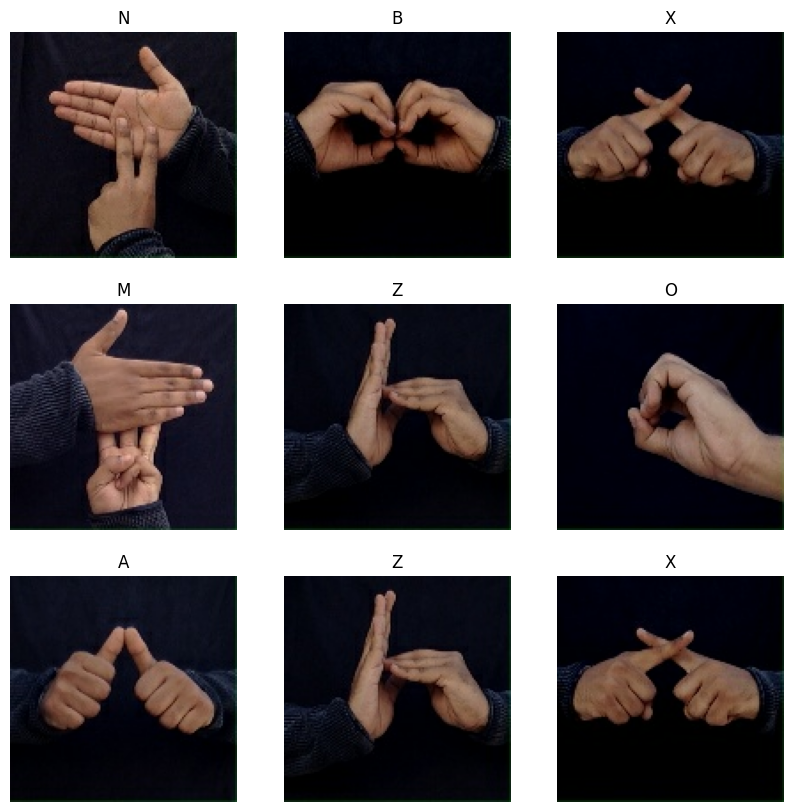

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [9]:
data_dir = "/content/dataset/Indian"  # change this path to your dataset
img_size = (128, 128)
batch_size = 32

# Load full dataset (with labels from folder names)
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Split into train & test (80/20)
ds_size = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.8 * ds_size)

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = full_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


Found 42745 files belonging to 35 classes.
Classes: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [10]:
# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,   # remove classifier head
    weights='imagenet'
)
base_model.trainable = False  # freeze weights

# Build model
model = models.Sequential([
    layers.Rescaling(1./255),           # normalize images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # classifier
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)


Epoch 1/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - accuracy: 0.9186 - loss: 0.3633 - val_accuracy: 1.0000 - val_loss: 3.7609e-05
Epoch 2/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9995 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 3.3923e-06
Epoch 3/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 1.0696e-07
Epoch 4/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 1.8185e-07
Epoch 5/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 8.8338e-09
Epoch 6/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 5.3977e-09
Epoch 7/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 6.7152e-06
Epoch 8/10
1068/1068 ━━━━━━━━━━━━━━━━━━━━ 18s 13

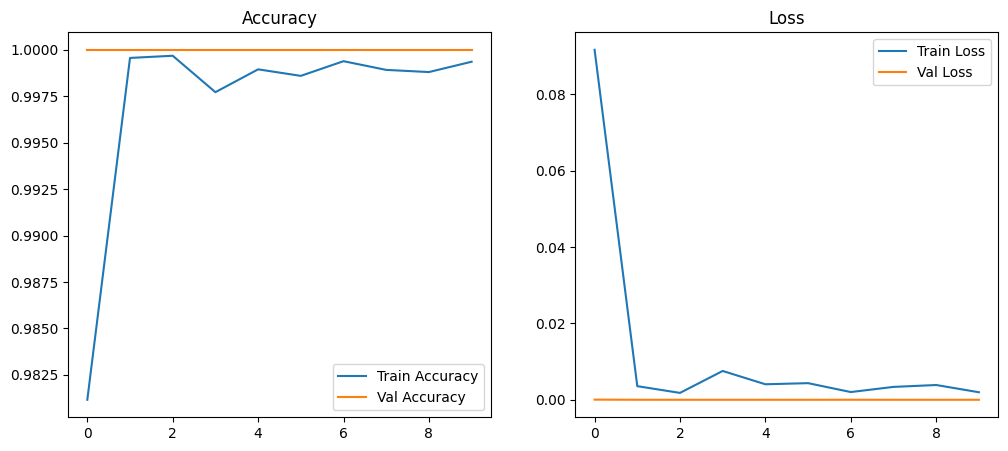

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()


In [14]:
# Save in Keras format
model.save("isl_sign_model.keras")



In [15]:
from tensorflow import keras

# Load model back
loaded_model = keras.models.load_model("isl_sign_model.keras")

# Test loading
loaded_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │         4,515 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,594,952 (9.90 MB)

 Trainable params: 168,483 (658.14 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 168,485 (658.15 KB)

In [27]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
import cv2
import numpy as np
import tensorflow as tf
from base64 import b64decode, b64encode
from PIL import Image
import io

# Helper to capture image from webcam in Colab
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize video to fit window
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture button click
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture image
img_path = take_photo()
print("Saved photo:", img_path)


<IPython.core.display.Javascript object>

Saved photo: photo.jpg


In [30]:
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

pred = loaded_model.predict(img_array)
predicted_class = np.argmax(pred[0])
print("Predicted:", class_names[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: C


In [31]:
print("Class Names:", class_names)


Class Names: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [32]:
trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_variables])

print("Trainable params:", trainable_params)
print("Non-trainable params:", non_trainable_params)
print("Total params:", trainable_params + non_trainable_params)


Trainable params: 168483
Non-trainable params: 2257986
Total params: 2426469
